In [34]:
from typing import List,TypedDict

from langchain_community.document_loaders import PyPDFLoader,PyPDFDirectoryLoader
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import  RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_huggingface import HuggingFaceEmbeddings
from pydantic import BaseModel
from langchain_community.tools import TavilySearchResults

from langgraph.graph import START,StateGraph,END
from dotenv import load_dotenv
import os
import re


In [2]:

load_dotenv()

OPENROUTER_API_KEY=os.getenv("OPENROUTER_API_KEY")
tavily_api_key=os.getenv("TAVILY_API_KEY")

os.environ["OPENROUTER_API_KEY"]=OPENROUTER_API_KEY
os.environ["TAVILY_API_KEY"]=tavily_api_key

model= ChatOpenAI( base_url="https://openrouter.ai/api/v1",
    api_key=OPENROUTER_API_KEY,
    model= "upstage/solar-pro-3:free"
)
model.invoke("hello")

AIMessage(content='Hello! 👋 I’m Solar\u202fOpen\u202f100B, a large language model developed by Upstage. How can I help you today? Feel free to ask any question, request assistance with writing, coding, translation, or anything else you have in mind.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 172, 'prompt_tokens': 69, 'total_tokens': 241, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': 0, 'reasoning_tokens': 111, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 64}, 'cost': 0, 'is_byok': False, 'cost_details': {'upstream_inference_cost': 0, 'upstream_inference_prompt_cost': 0, 'upstream_inference_completions_cost': 0}}, 'model_provider': 'openai', 'model_name': 'upstage/solar-pro-3:free', 'system_fingerprint': None, 'id': 'gen-1770930551-ED0TZBFE5My9uJFnV7U4', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019c53af-c61e-70f3-a986-d4a2aed91652-0

In [4]:
docs = (
    PyPDFLoader("./documents/book1.pdf").load()
    + PyPDFLoader("./documents/book2.pdf").load()
    + PyPDFLoader("./documents/book3.pdf").load()
)

In [5]:
chunks = RecursiveCharacterTextSplitter(chunk_size=900, chunk_overlap=150).split_documents(docs)
for d in chunks:
    d.page_content = d.page_content.encode("utf-8", "ignore").decode("utf-8", "ignore")

In [6]:
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
)


In [7]:
vector_store = FAISS.from_documents(chunks, embeddings)
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 4})

In [8]:
UPPER_TH = 0.7
LOWER_TH = 0.3

In [ ]:
class State(TypedDict):

    question: str
    docs: List[Document]

    good_docs: List[Document]
    verdict: str
    reason: str

    strips: List[str]
    kept_strips: List[str]
    refined_context: str

    web_docs: List[Document]   # ✅ added

    
    answer: str

In [10]:

def retrieve(state: State) -> State:
    q = state["question"]
    return {"docs": retriever.invoke(q)}

In [35]:
res=retrieve({'question':"AI news from the last month"})
res['docs']

[Document(id='e68ed990-2b3c-46ee-9fb9-d048691a9894', metadata={'producer': 'Antenna House PDF Output Library 6.2.609 (Linux64)', 'creator': 'AH CSS Formatter V6.2 MR4 for Linux64 : 6.2.6.18551 (2014/09/24 15:00JST)', 'creationdate': '2017-03-10T21:55:34+00:00', 'author': 'Aurélien Géron', 'moddate': '2017-07-29T21:43:02+08:00', 'title': 'Hands-On Machine Learning with Scikit-Learn and TensorFlow', 'trapped': '/False', 'source': './documents/book3.pdf', 'total_pages': 564, 'page': 275, 'page_label': '254'}, page_content='would soon be conversing with truly intelligent machines. When it became clear that\nthis promise would go unfulfilled (at least for quite a while), funding flew elsewhere\nand ANNs entered a long dark era. In the early 1980s there was a revival of interest in\nANNs as new network architectures were invented and better training techniques\nwere developed. But by the 1990s, powerful alternative Machine Learning techniques\nsuch as Support Vector Machines (see Chapter 5) 

In [45]:
# -----------------------------
# Score-based doc evaluator
# -----------------------------
class DocEvalScore(BaseModel):
    score: float
    reason: str

doc_eval_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a strict retrieval evaluator for RAG.\n"
            "You will be given ONE retrieved chunk and a question.\n"
            "Return a relevance score in [0.0, 1.0].\n"
            "- 1.0: chunk alone is sufficient to answer fully/mostly\n"
            "- 0.0: chunk is irrelevant\n"
            "Be conservative with high scores.\n"
            "Also return a short reason.\n"
            "Output JSON only.",
        ),
        ("human", "Question: {question}\n\nChunk:\n{chunk}"),
    ]
)

doc_eval_chain = doc_eval_prompt | model.with_structured_output(DocEvalScore)

def eval_each_doc_node(state: State) -> State:

    q = state["question"]
    
    scores: List[float] = []
    reasons: List[str] = []
    good: List[Document] = []

    for d in state["docs"]:
        out = doc_eval_chain.invoke({"question": q, "chunk": d.page_content})
        scores.append(out.score)
        reasons.append(out.reason)

        # 5) for CORRECT case we will refine only docs with score > LOWER_TH
        if out.score > LOWER_TH:
            good.append(d)

    # 2) CORRECT if at least one doc > UPPER_TH
    if any(s > UPPER_TH for s in scores):
        return {
            "good_docs": good,
            "verdict": "CORRECT",
            "reason": f"At least one retrieved chunk scored > {UPPER_TH}.",
        }

    # 3) INCORRECT if all docs < LOWER_TH
    if len(scores) > 0 and all(s < LOWER_TH for s in scores):
        why = "No chunk was sufficient."
        return {
            "good_docs": [],
            "verdict": "INCORRECT",
            "reason": f"All retrieved chunks scored < {LOWER_TH}. {why}",
        }

    # 4) Anything in between => AMBIGUOUS
    why = "Mixed relevance signals."
    return {
        "good_docs": good,
        "verdict": "AMBIGUOUS",
        "reason": f"No chunk scored > {UPPER_TH}, but not all were < {LOWER_TH}. {why}",
    }

In [52]:
eval_res=eval_each_doc_node({'question':"AI news from the last month",'docs':res['docs']})
eval_res

{'good_docs': [],
 'verdict': 'INCORRECT',
 'reason': 'All retrieved chunks scored < 0.3. No chunk was sufficient.'}

In [53]:
# -----------------------------
# Sentence-level DECOMPOSER
# -----------------------------
def decompose_to_sentences(text: str) -> List[str]:
    text = re.sub(r"\s+", " ", text).strip()
    sentences = re.split(r"(?<=[.!?])\s+", text)
    return [s.strip() for s in sentences if len(s.strip()) > 20]

# -----------------------------
# FILTER (LLM judge)
# -----------------------------
class KeepOrDrop(BaseModel):
    keep: bool

filter_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a strict relevance filter.\n"
            "Return keep=true only if the sentence directly helps answer the question.\n"
            "Use ONLY the sentence. Output JSON only.",
        ),
        ("human", "Question: {question}\n\nSentence:\n{sentence}"),
    ]
)

filter_chain = filter_prompt | model.with_structured_output(KeepOrDrop)

# -----------------------------
# REFINING (Decompose -> Filter -> Recompose)
# -----------------------------
def refine(state: State) -> State:
    q = state["question"]

    if state.get("verdict") == "CORRECT":
        context = "\n\n".join(d.page_content for d in state["good_docs"]).strip()
    else:
        context = "\n\n".join(d.page_content for d in state["web_docs"]).strip()
        

    strips = decompose_to_sentences(context)
 
    kept: List[str] = []
    for s in strips:
        if filter_chain.invoke({"question": q, "sentence": s}).keep:
            kept.append(s)

    refined_context = "\n".join(kept).strip()

    return {
        "strips": strips,
        "kept_strips": kept,
        "refined_context": refined_context,
    }

In [54]:
# -----------------------------
# Web search (Iteration 4)
# Assumption: web search does not fail (no fail node in this branch)
# -----------------------------
tavily = TavilySearchResults(max_results=5,
                            TAVILY_API_KEY=tavily_api_key)

def web_search_node(state: State) -> State:

    q = state["question"]  # no query rewrite
    results = tavily.invoke({"query": q})  # no knowledge selection


    web_docs = []
    for r in results or []:

        title = r.get("title", "")
        url = r.get("url", "")
        content = r.get("content", "") or r.get("snippet", "")
        
        text = f"TITLE: {title}\nURL: {url}\nCONTENT:\n{content}"

        web_docs.append(Document(page_content=text, metadata={"url": url, "title": title}))

    return {"web_docs": web_docs}

In [24]:
web_res=web_search_node({'question':"AI news from the last month"})
web_res

web result:---> [{'title': 'Latest AI News and AI Breakthroughs that Matter Most: 2026 & 2025', 'url': 'https://www.crescendo.ai/news/latest-ai-news-and-updates', 'content': 'Summary: San Francisco-based startup Exa has closed an $85 million Series\u202fB round led by Benchmark, valuing the company at approximately $700 million. Investors also include Lightspeed, NVIDIA’s NVentures, and Y Combinator. Benchmark’s Peter Fenton will join Exa’s board, bolstering the firm’s leadership as it scales. Exa offers a search engine and API crafted specifically for AI agents, delivering structured content from the web with sub-450\u202fms latency and zero data retention. Its flagship products—Search API and Websets—serve thousands of enterprise clients, including AI startups like Cursor and major firms in consulting and research. The new funding will be used to expand its indexing infrastructure, grow its GPU cluster by fivefold, and scale engineering and go-to-market teams as it [...] \u200dDate: 

{'web_docs': [Document(metadata={'url': 'https://www.crescendo.ai/news/latest-ai-news-and-updates', 'title': 'Latest AI News and AI Breakthroughs that Matter Most: 2026 & 2025'}, page_content='TITLE: Latest AI News and AI Breakthroughs that Matter Most: 2026 & 2025\nURL: https://www.crescendo.ai/news/latest-ai-news-and-updates\nCONTENT:\nSummary: San Francisco-based startup Exa has closed an $85 million Series\u202fB round led by Benchmark, valuing the company at approximately $700 million. Investors also include Lightspeed, NVIDIA’s NVentures, and Y Combinator. Benchmark’s Peter Fenton will join Exa’s board, bolstering the firm’s leadership as it scales. Exa offers a search engine and API crafted specifically for AI agents, delivering structured content from the web with sub-450\u202fms latency and zero data retention. Its flagship products—Search API and Websets—serve thousands of enterprise clients, including AI startups like Cursor and major firms in consulting and research. The ne

In [ ]:
ref_res=refine({'question':"AI news from the last month",'verdict':'INCORRECT','web_docs':web_res['web_docs']})
ref_res

In [16]:
res = tavily.invoke({"query": "AI news from the last month"})
res

[{'title': 'AI News | Latest News | Insights Powering AI-Driven Business Growth',
  'url': 'https://www.artificialintelligence-news.com/',
  'content': 'Infrastructure & Hardware\n\nFebruary 10, 2026\n\n# Chinese hyperscalers and industry-specific agentic AI\n\nPhoto by Logan Voss/Unsplash\n\nHealthcare & Wellness AI\n\nFebruary 10, 2026\n\n# Agentic AI in healthcare: How Life Sciences marketing could achieve $450B in value by 2028\n\nPhoto by Markus Spiske/Unsplash\n\nAI and Us\n\nFebruary 9, 2026\n\n# Exclusive: Why are Chinese AI models dominating open-source as Western labs step back?\n\nAI and Us\n\nFebruary 5, 2026\n\n# AI Expo 2026 Day 2: Moving experimental pilots to AI production\n\nAI in Action\n\nFebruary 5, 2026\n\n# OpenAI’s enterprise push: The hidden story behind AI’s sales race [...] AI News is part of the TechForge Publications series\n\nTechForge\n\nphoto by SCARECROW artworks/Unsplashphoto by SCARECROW artworks/Unsplash\n\nCybersecurity AI\n\n# Google identifies stat

In [55]:
answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful ML tutor. Answer ONLY using the provided context.\n"
            "If the context is empty or insufficient, say: 'I don't know.'",
        ),
        ("human", "Question: {question}\n\nRefined context:\n{refined_context}"),
    ]
)

def generate(state: State) -> State:
    out = (answer_prompt | model).invoke(
        {"question": state["question"], "refined_context": state["refined_context"]}
    )
    return {"answer": out.content}

In [56]:
def ambiguous_node(state: State) -> State:
    return {"answer": f"Ambiguous: {state['reason']}"}

def route_after_eval(state: State) -> str:
    if state["verdict"] == "CORRECT":
        return "refine"
    elif state["verdict"] == "INCORRECT":
        return "web_search"
    else:
        return "ambiguous"

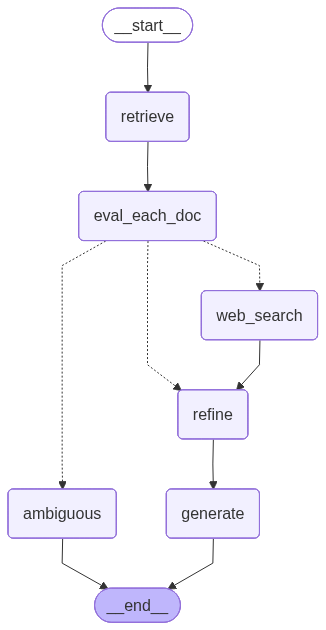

In [57]:
# -----------------------------
# Graph
# -----------------------------
g = StateGraph(State)

g.add_node("retrieve", retrieve)
g.add_node("eval_each_doc", eval_each_doc_node)
g.add_node("web_search", web_search_node)
g.add_node("refine", refine)          # uses verdict to pick good_docs vs web_docs
g.add_node("generate", generate)
g.add_node("ambiguous", ambiguous_node)

# flow
g.add_edge(START, "retrieve")
g.add_edge("retrieve", "eval_each_doc")

# route after evaluation
g.add_conditional_edges(
    "eval_each_doc",
    route_after_eval,
    {
        "refine": "refine",          # CORRECT -> refine (good_docs)
        "web_search": "web_search",  # INCORRECT -> web_search
        "ambiguous": "ambiguous",    # AMBIGUOUS -> end (your current choice)
    },
)

# ✅ key change: web_search now goes through refine
g.add_edge("web_search", "refine")    # INCORRECT -> refine (web_docs)
g.add_edge("refine", "generate")      # CORRECT/INCORRECT -> generate

g.add_edge("generate", END)
g.add_edge("ambiguous", END)

app = g.compile()
app

In [58]:
res = app.invoke(
    {
        "question": "AI news from the last month",
        "docs": [],
        "good_docs": [],
        "verdict": "",
        "reason": "",
        "strips": [],
        "kept_strips": [],
        "refined_context": "",
        "web_docs": [],   # ✅ added
        "answer": "",
    }
)

print("VERDICT:", res["verdict"])
print("REASON:", res["reason"])
print("\nOUTPUT:\n", res["answer"])

VERDICT: INCORRECT
REASON: All retrieved chunks scored < 0.3. No chunk was sufficient.

OUTPUT:
 **AI news from the last month (January – February 2026)**  

- **January 2026** – *The White House* released the report **“Artificial Intelligence and the Great Divergence.”** It reviews analyses of AI‑led economic growth and estimates AI’s impact on both GDP and the labor force.  

- **Feb 9, 2026** – *Exclusive* article asks **“Why are Chinese AI models dominating open‑source as Western labs step back?”**  

- **Feb 10, 2026** –  
  • **Infrastructure & Hardware:** Chinese hyperscalers are advancing **industry‑specific agentic AI** solutions.  
  • **Healthcare & Wellness:** Agentic AI in healthcare could enable Life‑Sciences marketing to create **$450 B in value by 2028.**  

- **Feb 11, 2026** –  
  • **Finance AI:** Insurance leaders are using **agentic AI** to **cut operational costs**.  
  • **Developer Tech:** Android 17 beta introduces **continuous Canary updates for developers**, 